In [93]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

## 모델에 input하여, 주간 지수값 생성

In [94]:
# 최종 모델
model = pickle.load(open('./final_model.pkl','rb'))
# 생성한 주간 지수 값 테이블
weeklydata = pickle.load(open('./final_table.pkl','rb'))

In [95]:
weeklydata

,date,keyword1,keyword2,keyword3,keyword4,keyword5,google,naver,ccsi,weeklyCLI
0,2016.1.4,825,419,437,986,168,53.0,26.05846,99.5,100.114651
1,2016.1.11,770,348,351,626,182,58.0,25.16599,99.5,100.218829
2,2016.1.18,918,422,441,445,147,74.0,27.38639,99.5,96.924625
3,2016.1.25,1067,425,567,383,148,59.0,24.72622,99.5,90.786863
4,2016.2.1,899,341,485,289,110,63.0,23.01888,97.2,90.612911
...,...,...,...,...,...,...,...,...,...,...
247,2020.9.28,489,90,114,95,78,63.0,25.29102,79.4,101.857171
248,2020.10.5,816,183,177,109,78,81.0,28.63240,91.6,104.707534
249,2020.10.12,857,199,176,112,91,82.0,26.85177,91.6,100.781811
250,2020.10.19,911,155,143,95,129,93.0,27.25273,91.6,100.454511


## 유효성 확인

* test set의 주간 지수와 소비자심리지수의 상관계수 확인 <br>
: 상관계수가 0.776009로 강한 양의 상관관계를 갖는다. 

In [96]:
X_train = pickle.load(open('./dataset/dataset_mean/X_train.pkl','rb'))
y_train = pickle.load(open('./dataset/dataset_mean/y_train.pkl','rb'))
X_test = pickle.load(open('./dataset/dataset_mean/X_test.pkl','rb'))
y_test = pickle.load(open('./dataset/dataset_mean/y_test.pkl','rb'))
scaler = pickle.load(open('./final_scaler.pkl','rb'))
y_pred = model.predict( scaler.transform(X_test) )

In [97]:
test = pd.DataFrame()
test['ccsi'] = y_test['ccsi'].tolist()
test['weeklyCLI'] = y_pred

In [98]:
test[['weeklyCLI', 'ccsi']].corr(method = 'pearson') 

,weeklyCLI,ccsi
weeklyCLI,1.000000,0.776009
ccsi,0.776009,1.000000


* test set에 대한 RMSE <br>
: 8.4384

In [99]:
print("test RMSE about weekly CCSI: ", np.sqrt(mean_squared_error(test['weeklyCLI'], test['ccsi'])))

test RMSE about weekly CCSI:  8.43842267189124


* 전체 레코드에 대한 RMSE <br>
: 4.8075로 작은 값. ccsi의 추세를 잘 따라간다.

In [100]:
print("RMSE about weekly CCSI: ", np.sqrt(mean_squared_error(weeklydata['weeklyCLI'], weeklydata['ccsi'])))

RMSE about weekly CCSI:  4.807544722268003


* 개발한 주간 경제보조지수가 월간 경제 지표인 소비자 심리지수의 추세를 잘 따르는지 확인<br><br>
: 시각화결과, 펜데믹 사태로 인해 경제 상황이 안좋아진 2020년에 대해서는 매우 좋은 예측력을 보이지는 않았다. 따라서 2020년의 데이터를 살펴보며 추가적인 사후분석을 하고자 한다.

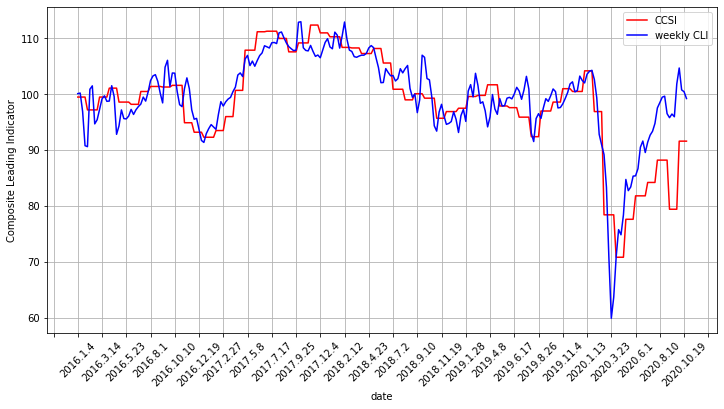

In [101]:
plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(weeklydata['date'], weeklydata['ccsi'], color = 'red', label = 'CCSI')
plt.plot(weeklydata['date'], weeklydata['weeklyCLI'], color = 'blue', label = 'weekly CLI')
plt.xlabel("date")
plt.ylabel("Composite Leading Indicator")
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(45)
plt.grid(True)
plt.legend()
plt.show()

* google 변수가 라쏘회귀모형에서 0으로 추정된 원인 분석 <br><br>
1) true y(CCSI)와의 변수들의 상관관계<br>
라쏘회귀는 y와의 상관관계가 큰 것부터 삭제하는 경향이 있기 때문이다. <br>
그러나, keyword4가 더 작은 상관관계를 갖는다. 따라서 규제항이 없는 다중선형회귀의 계수를 살펴본다. <br><br>
2) 규제항이 없는 다중선형회귀의 계수<br>
X5(google)변수의 계수가 가장 작다. 즉, y에 미치는 영향력이 가장 작음을 알 수 있다.

In [102]:
ccsi = y_train.ccsi.tolist()
train = X_train
train['ccsi'] = ccsi
X_train.corr().iloc[7,]

keyword1   -0.844307
keyword2   -0.666754
keyword3   -0.655859
keyword4   -0.259032
keyword5   -0.422807
google     -0.359626
naver      -0.367600
ccsi        1.000000
Name: ccsi, dtype: float64

In [103]:
X_train = pd.DataFrame(X_train, columns = ['keyword1', 'keyword2', 'keyword3', 'keyword4', 'keyword5', 'google', 'naver'])
X_train = scaler.transform(X_train)
model = LinearRegression()
model.fit(X_train, y_train)

print(model.intercept_)
print(model.coef_)

[101.48043478]
[[-1.9933191  -0.57215325 -2.91204942  1.2552704  -0.39581953  0.31177325
  -2.46446548]]


## 사후 분석

* lasso model의 계수 <br><br>
lasso model의 계수를 확인한 결과 6번째 변수인 google의 계수가 0임을 알 수 있다. 따라서 google의 가중치가 0이므로 변수 7개 중 6개만 사용된다. keyword1, keyword2, keyword3, keyword5, naver의 계수는 음수이고 keyword4의 계수만 양수이다.

In [51]:
model.coef_

array([-2.24465305, -0.31591057, -2.56756448,  0.90718337, -0.39515066,
        0.        , -1.95358518])

* 뉴스기사수를 세는 키워드들의 box plot

In [52]:
data = weeklydata.iloc[:,[1,2,3,4,5,6,7]]


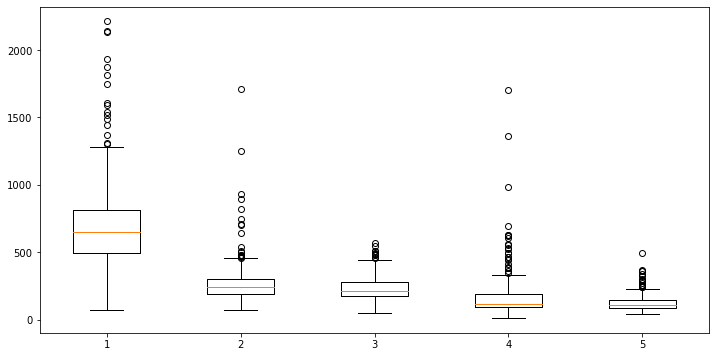

In [53]:
plot_data = [data.keyword1, data.keyword2, data.keyword3, data.keyword4, data.keyword5]
ax = plt.boxplot(plot_data)
plt.show()

* 예측변수들간의 상관계수 <br>
다중공선성이 존재하는지 확인한다.

In [54]:
data.corr()

,keyword1,keyword2,keyword3,keyword4,keyword5,google,naver
keyword1,1.000000,0.772901,0.324893,0.544286,0.669054,0.601180,0.605412
keyword2,0.772901,1.000000,0.288222,0.714644,0.691381,0.422582,0.698026
keyword3,0.324893,0.288222,1.000000,0.176619,0.183746,-0.076229,-0.093266
keyword4,0.544286,0.714644,0.176619,1.000000,0.418494,0.265786,0.575139
keyword5,0.669054,0.691381,0.183746,0.418494,1.000000,0.454692,0.505565
google,0.601180,0.422582,-0.076229,0.265786,0.454692,1.000000,0.675322
naver,0.605412,0.698026,-0.093266,0.575139,0.505565,0.675322,1.000000


- 2016.01~2019.10:train set
- 2019.11~2020.10: test set<br><br>
test set으로 사용된 data 중 2019년 11월, 12월, 2020년 1월은 잘 추정된 것을 확인할 수 있으나 코로나로 인해 경제상황이 악화된 2020년의 예측력은 좋지 않음을 확인할 수 있다. 2020년 2월, 3월은 ccsi 보다 낮게 예측이 되고 2020년 4월 이후부터는 ccsi보다 높게 예측되는 것을 볼 수 있다.

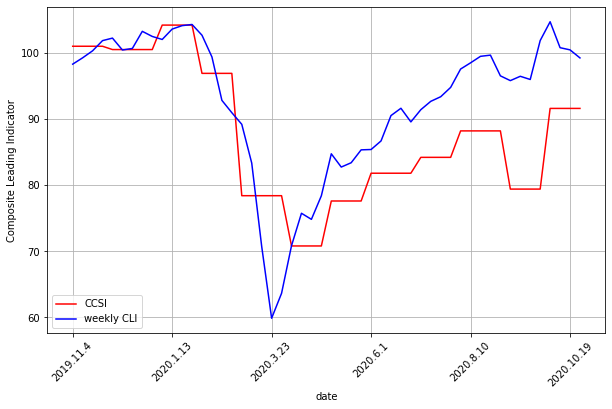

In [55]:
plt.rcParams["figure.figsize"] = (10, 6)
plt.plot(weeklydata['date'][200:], weeklydata['ccsi'][200:], color = 'red', label = 'CCSI')
plt.plot(weeklydata['date'][200:], weeklydata['weeklyCLI'][200:], color = 'blue', label = 'weekly CLI')
plt.xlabel("date")
plt.ylabel("Composite Leading Indicator")
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(45)
plt.grid(True)
plt.legend()
plt.show()

각 data들의 column 별로 max값을 가지는 날짜를 본 결과 2020년 3월에 몰려있는 것을 볼 수 있다. 실제 데이터를 확인한 결과 모든 변수들이 2020년 3월에 큰 값을 가지는 것을 확인할 수 있다. 우리의 라쏘 모델은 keyword4를 제외한 모든 변수가 음의 계수를 가지므로 ccsi가 매우 낮게 예측된다. 

In [56]:
index = max(enumerate(weeklydata['keyword1']), key=(lambda x: x[1]))[0]
print(weeklydata['date'][index])
index = max(enumerate(weeklydata['keyword2']), key=(lambda x: x[1]))[0]
print(weeklydata['date'][index])
index = max(enumerate(weeklydata['keyword3']), key=(lambda x: x[1]))[0]
print(weeklydata['date'][index])
index = max(enumerate(weeklydata['keyword4']), key=(lambda x: x[1]))[0]
print(weeklydata['date'][index])
index = max(enumerate(weeklydata['keyword5']), key=(lambda x: x[1]))[0]
print(weeklydata['date'][index])
index = max(enumerate(weeklydata['naver']), key=(lambda x: x[1]))[0]
print(weeklydata['date'][index])

2020.3.23
2020.3.16
2016.1.25
2020.3.9
2020.4.20
2020.3.16


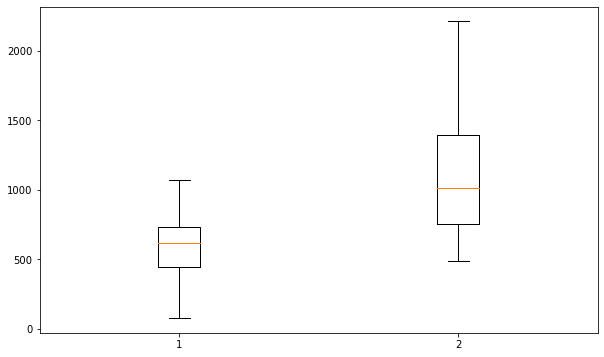

In [57]:
plot_data = [weeklydata['keyword1'][:200], weeklydata['keyword1'][200:]]
ax = plt.boxplot(plot_data)
plt.show()

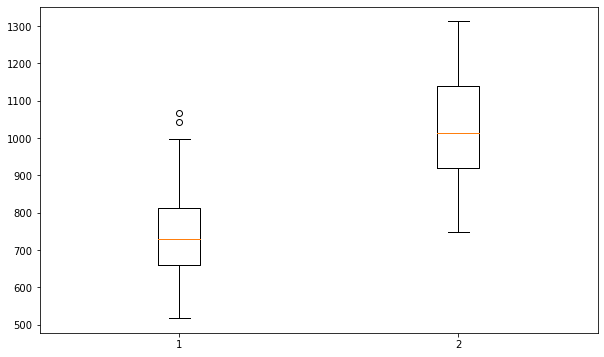

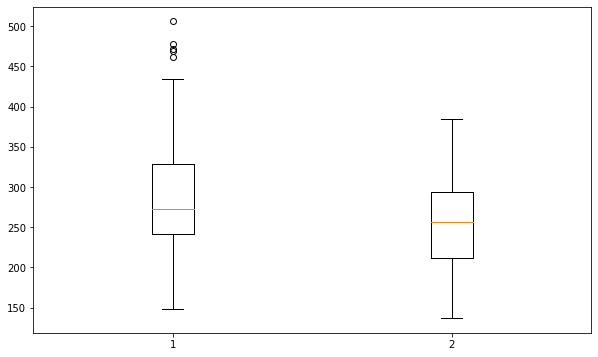

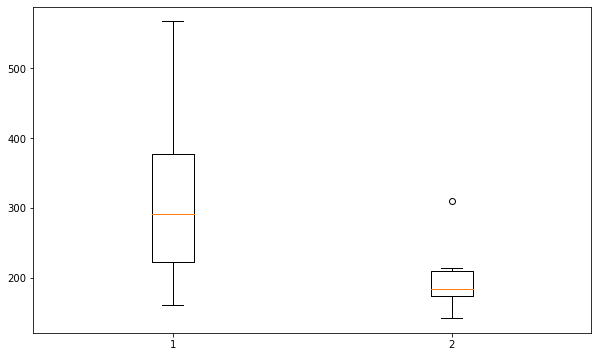

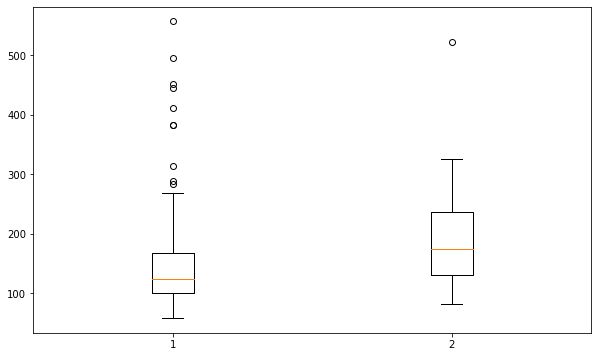

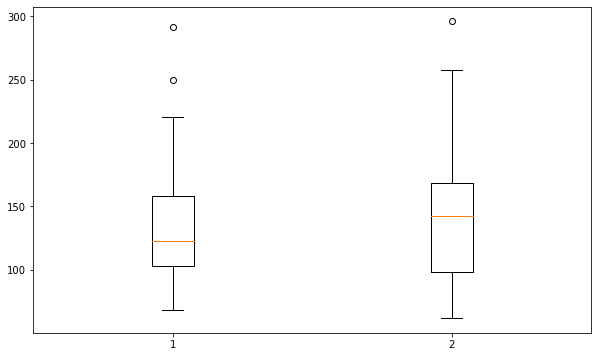

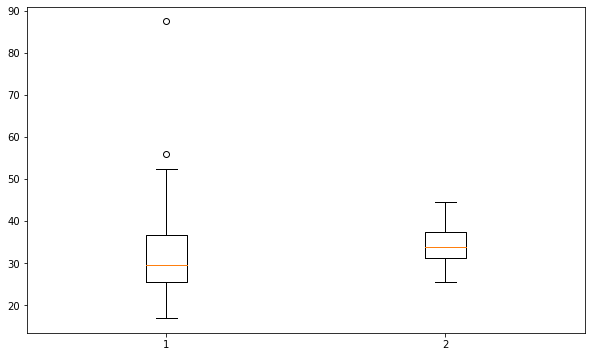

In [58]:
train_array = []
for i in range(0, 200):
    if weeklydata['weeklyCLI'][i] >= 90 and weeklydata['weeklyCLI'][i] <= 100:
        train_array.append([weeklydata['keyword1'][i], weeklydata['keyword2'][i], weeklydata['keyword3'][i], weeklydata['keyword4'][i], weeklydata['keyword5'][i], weeklydata['naver'][i], 1])
train_array = np.array(train_array)

test_array = []
for i in range(200, len(weeklydata)):
    if weeklydata['weeklyCLI'][i] >= 90 and weeklydata['weeklyCLI'][i] <= 100:
        test_array.append([weeklydata['keyword1'][i], weeklydata['keyword2'][i], weeklydata['keyword3'][i], weeklydata['keyword4'][i], weeklydata['keyword5'][i], weeklydata['naver'][i], 2])
test_array = np.array(test_array)


plot_data = [train_array[:, 0], test_array[:, 0]]
ax = plt.boxplot(plot_data)
plt.show()
plot_data = [train_array[:, 1], test_array[:, 1]]
ax2 = plt.boxplot(plot_data)
plt.show()
plot_data = [train_array[:, 2], test_array[:, 2]]
ax3 = plt.boxplot(plot_data)
plt.show()
plot_data = [train_array[:, 3], test_array[:, 3]]
ax3 = plt.boxplot(plot_data)
plt.show()
plot_data = [train_array[:, 4], test_array[:, 4]]
ax3 = plt.boxplot(plot_data)
plt.show()
plot_data = [train_array[:, 5], test_array[:, 5]]
ax3 = plt.boxplot(plot_data)
plt.show()

* keyword4(불황) 분석 <br><br>
불황키워드는 뉴스키워드 변수 중 유일하게 양의 계수를 갖는다. 그 이유를 살펴보자. <br>



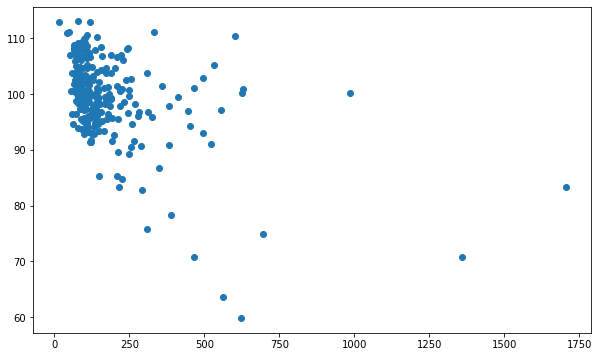

In [59]:
# 다른 변수들을 고정한 후, keyword4를 정렬한다. 개발한 주간 경제심리보조지수와의 관계를 파악한다.
aa = weeklydata.sort_values(by=['keyword4'], axis=0)[['keyword4', 'weeklyCLI']] 
plt.scatter(aa['keyword4'],aa['weeklyCLI']) # 두 변수의 독립적인 관계를 파악하면, 음의 관계

* 전체 데이터에 대한 keyword1의 시계열 데이터

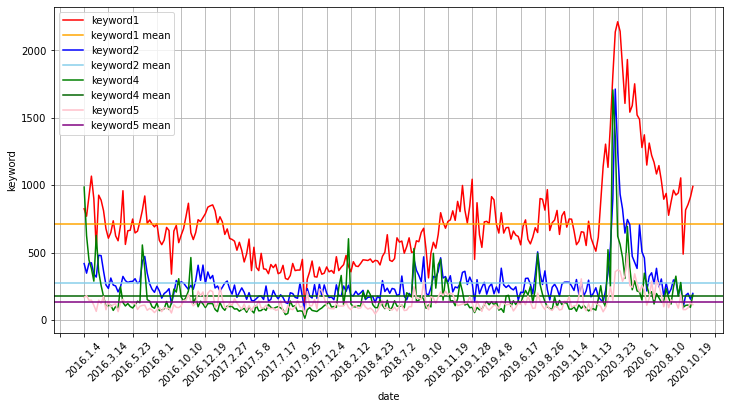

In [65]:
plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(weeklydata['date'], weeklydata['keyword1'], color = 'red', label = 'keyword1')
plt.axhline(y=weeklydata['keyword1'].mean(), color = 'orange', label = 'keyword1 mean')
plt.plot(weeklydata['date'], weeklydata['keyword2'], color = 'blue', label = 'keyword2')
plt.axhline(y=weeklydata['keyword2'].mean(), color = 'skyblue', label = 'keyword2 mean')
plt.plot(weeklydata['date'], weeklydata['keyword4'], color = 'green', label = 'keyword4')
plt.axhline(y=weeklydata['keyword4'].mean(), color = 'darkgreen', label = 'keyword4 mean')
plt.plot(weeklydata['date'], weeklydata['keyword5'], color = 'pink', label = 'keyword5')
plt.axhline(y=weeklydata['keyword5'].mean(), color = 'purple', label = 'keyword5 mean')

plt.xlabel("date")
plt.ylabel("keyword")
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(45)
plt.grid(True)
plt.legend()
plt.show()

* 전체 데이터에 대한 keyword3의 시계열 데이터 <br><br>
키워드3에 대해서만 2020년이 상대적으로 낮은 값을 갖는다.

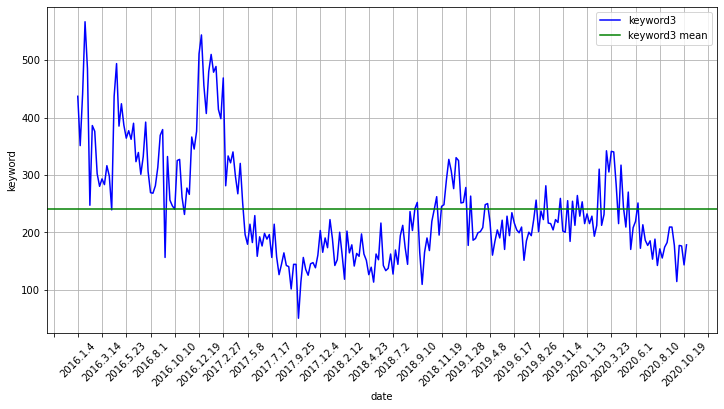

In [64]:
plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(weeklydata['date'], weeklydata['keyword3'], color = 'blue', label = 'keyword3')
plt.axhline(y=weeklydata['keyword3'].mean(), color = 'green', label = 'keyword3 mean')
plt.xlabel("date")
plt.ylabel("keyword")
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(45)
plt.grid(True)
plt.legend()
plt.show()

* 전체 데이터에 대한 네이버 변수의 시계열 데이터

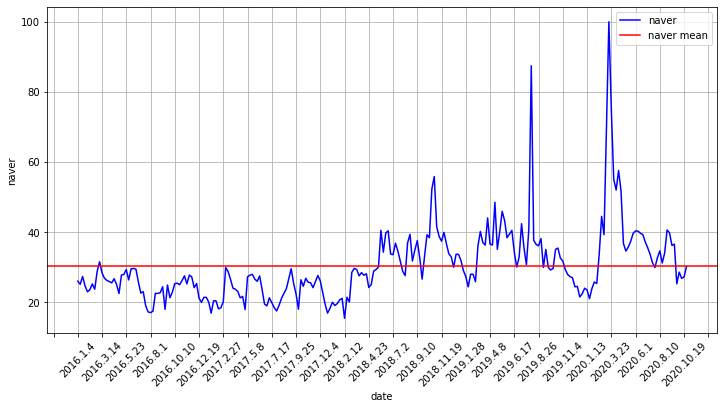

In [62]:
plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(weeklydata['date'], weeklydata['naver'], color = 'blue', label = 'naver')
plt.axhline(y=weeklydata['naver'].mean(), color = 'red', label = 'naver mean')
plt.xlabel("date")
plt.ylabel("naver")
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(45)
plt.grid(True)
plt.legend()
plt.show()